# FacePointX - Facial keypoints detector

### Dependencies

In [57]:
import os
import cv2
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import sklearn

In [2]:
import warnings 
warnings.filterwarnings("ignore")

### Preparing the Data

In [3]:
train_csv_filepath = os.path.join("Data","training.csv")
train_df = pd.read_csv(train_csv_filepath)
train_df["Image"] = train_df["Image"].apply(lambda x: np.fromstring(x, sep = " ").reshape(96,96,1))
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,"[[[238.0], [236.0], [237.0], [238.0], [240.0],..."
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,"[[[219.0], [215.0], [204.0], [196.0], [204.0],..."
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,"[[[144.0], [142.0], [159.0], [180.0], [188.0],..."
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,"[[[193.0], [192.0], [193.0], [194.0], [194.0],..."
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,"[[[147.0], [148.0], [160.0], [196.0], [215.0],..."


In [4]:
print(train_df.isnull().sum())
# train_df.fillna(train_df.mean(),inplace = True)
# train_df.head()
train_df.dropna(how = "any",inplace = True)
print(train_df.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [26]:
X_imgs = np.stack(train_df["Image"].values) / 255.0
y = train_df.drop(columns = ["Image"]).values

In [ ]:
print(y.dtype())

AttributeError: 'numpy.ndarray' object has no attribute 'to_numeric'

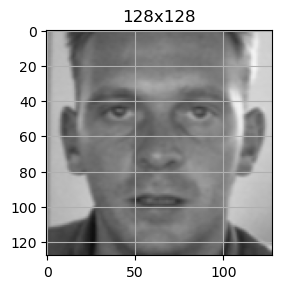

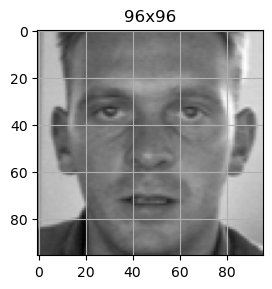

In [6]:
X_resized = np.array([cv2.resize(img, (128, 128)) for img in X_imgs])
X_resized = X_resized[..., np.newaxis]
X_resized = np.repeat(X_resized, 3, axis=-1)

plt.subplot(1,2,1)
plt.imshow(X_resized[2])
plt.title("128x128")
plt.grid(True)
plt.show()

plt.subplot(1,2,2)
plt.imshow(X_imgs[2], cmap="gray")
plt.title("96x96")
plt.grid(True)
plt.show()

### Feature Extraction

In [42]:
def Feature_Extraction(image):
    base = MobileNetV2(weights = "imagenet",include_top = False,input_shape = (128,128,3))
    base.trainable = False
    out = GlobalAveragePooling2D()(base.output)
    model = Model(inputs = base.input,outputs = out)
    features = model.predict(image)
    return features

In [43]:
X_train_features = Feature_Extraction(X_resized)
print(X_train_features)

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
[[0.         0.         0.08430126 ... 0.5940291  0.4827765  0.        ]
 [0.10603178 0.         0.24210255 ... 1.3498011  0.25151008 0.        ]
 [0.5684568  0.         0.         ... 0.08170809 0.         0.        ]
 ...
 [0.         0.         0.26079905 ... 0.3172947  2.5742383  0.        ]
 [0.         0.         0.00930712 ... 1.4719021  0.         0.        ]
 [0.         0.         0.04458939 ... 0.6985774  0.         0.        ]]


### Preprocessing

In [50]:
def Preprocessing(data):
    scalar = StandardScaler()
    features = scalar.fit_transform(data)
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    return features,pca_features

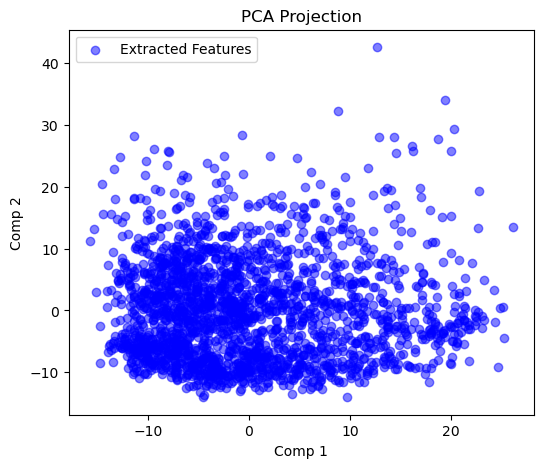

In [51]:
processed_X_train_features,processed_pca_features = Preprocessing(X_train_features)

plt.figure(figsize=(6, 5))
plt.scatter(processed_pca_features[:, 0],processed_pca_features[:, 1], alpha=0.5, c='b', label="Extracted Features")
plt.title("PCA Projection")
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.legend()
plt.show()

### Building the model

In [52]:
est = xgb.XGBRegressor(objective="reg:squarederror",device = "gpu",tree_method = "hist",n_estimators = 500,verbose = 2)

param_grid = {
    "learning_rate":[0.1,0.01,0.2],
    "max_depth":[3,6,9],
    "colsample_bytree":[0.3,0.5,0.7],
    "n_estimators":[300,500,700]
}

In [54]:
models_l = []
n = 0
for i in range(y.shape[1]):
    model = xgb.XGBRegressor(objective="reg:squarederror",device = "gpu",tree_method = "hist",n_estimators = 500,verbose = 2)
    model.fit(processed_X_train_features,y[:,i])
    n+=1
    print(f"[{n}]===============================DONE")
    models_l.append(model)


[1]===============================DONE
[2]===============================DONE
[3]===============================DONE
[4]===============================DONE
[5]===============================DONE
[6]===============================DONE
[7]===============================DONE
[8]===============================DONE
[9]===============================DONE
[10]===============================DONE
[11]===============================DONE
[12]===============================DONE
[13]===============================DONE
[14]===============================DONE
[15]===============================DONE
[16]===============================DONE
[17]===============================DONE
[18]===============================DONE
[19]===============================DONE
[20]===============================DONE
[21]===============================DONE
[22]===============================DONE
[23]===============================DONE
[24]===============================DONE
[25]===============================DONE
[26]=====

In [58]:
model_dict = {f"model_{i}": models_l[i] for i in range(30)}
joblib.dump(model_dict,"model-v1.pkl")

['model-v1.pkl']